In [1]:
# common imports
from pathlib import Path
import os
import numpy as np
import pandas as pd
import seaborn as sns
# sci-kit learn is our one-stop shop for machine learning!
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
# read in the dataset
filepath = Path.joinpath(Path.cwd().parent, 'data', 'Video_Games_Sales_as_at_22_Dec_2016.csv')
games = pd.read_csv(filepath)

In [3]:
# data set info
games.shape

(16719, 16)

In [4]:
# what is the data look like
games.head(5)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# check null data
games.isnull().sum().sort_values(ascending=False).head(10)

User_Count         9129
Critic_Score       8582
Critic_Count       8582
Rating             6769
User_Score         6704
Developer          6623
Year_of_Release     269
Publisher            54
Name                  2
Genre                 2
dtype: int64

# many missing data. Do the following the clean up the data
1. Drop columns that are unrelevant to this analysis ('Developer', 'User_Count', 'Critic_Count'
2. Fill in 'Unknown' for 'Rating' and 'Publisher'
3. Make datatype consistent for modeling
4. Fill nan score value with mean value for the column
5. Drop rest of the nan value

In [6]:
# 1. drop columns
games.drop(['Developer'] ,inplace =True, axis =1)
games.drop(['Critic_Count'] ,inplace =True, axis =1)
games.drop(['User_Count'] ,inplace =True, axis =1)

In [7]:
# 2. fill default value
games['Rating'] = games['Rating'].fillna("Unknown")
games['Publisher'] = games['Publisher'].fillna("Unknown")

In [8]:
# 3. check column datatype
games.dtypes

Name                object
Platform            object
Year_of_Release    float64
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
User_Score          object
Rating              object
dtype: object

While Critic_Score is float64, User_Score is an object. Let's User_Score to float64. Before that, let's check what's in User_Score first, some values might not be convertable

In [9]:
# check what User_Score could be
games['User_Score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [10]:
# Drop row with 'nan' or 'tbd' score
games = games[games.User_Score != 'tbd']
#games.dropna(subset = ["User_Score"], inplace=True)

In [11]:
# User score is not numeric type, change it and scale it to the samem scale with Critic_Score
games['User_Score'] = games['User_Score'].astype('float64')

In [ ]:
# check null data again
games.isnull().sum().sort_values(ascending=False).head(10)

Still a few null value in Critic_Score and Year_of_Release, but not that much compared to the whole dataset. Drop them

In [15]:
games['User_Score'].fillna(value=games['User_Score'].mean(), inplace=True)
games['Critic_Score'].fillna(value=games['Critic_Score'].mean(), inplace=True)

In [17]:
#Still a few null value in Critic_Score and Year_of_Release, but not that much compared to the whole dataset. Drop them
games.dropna(inplace=True)

In [18]:
games.shape

(14071, 13)

<AxesSubplot:>

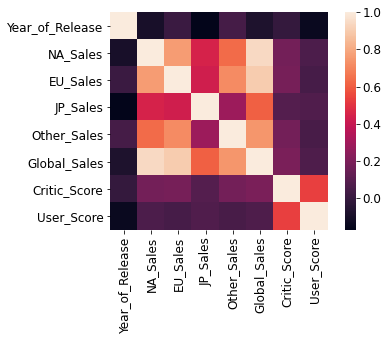

In [19]:
# check correlations, sales columns have strong correlation. We can use Global Sales the only target
sns.heatmap(games.corr(), vmax=1, square=True)

<AxesSubplot:>

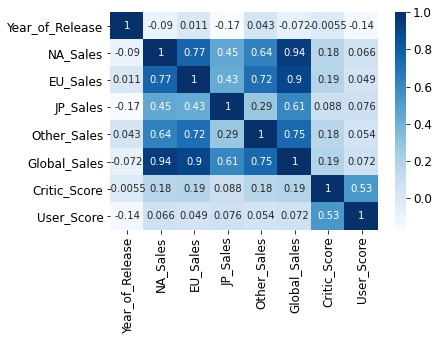

In [21]:
sns.heatmap(games.corr(),annot=True,cmap='Blues', fmt='.2g')

From the heat map, these have strong correlations
- NA_SALES and EU_SALES
- NA_SALES and Other_SALES
- Global Sales and all other type of Sales (this makes sense as Global Sales are the total of others). No need to further model this
- Critic_Score and Global Sales (not very strong, but let's still build a model based on that to predict sales
User_Score doesn't seem to have too much correlation with sales

[(0.0, 17.5)]

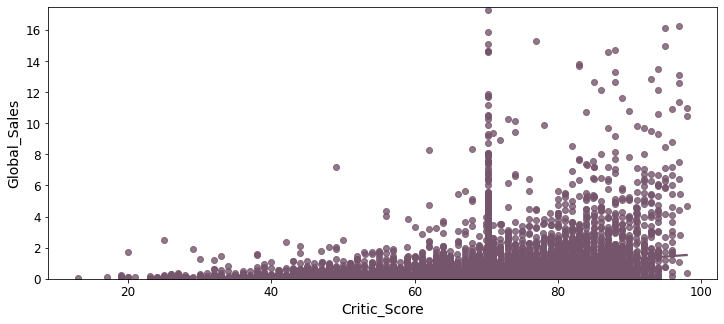

In [77]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.regplot(x="Critic_Score", y="Global_Sales", data=games, ci=None, color="#75556c", x_jitter=.02).set(ylim=(0, 17.5))

[(0.0, 17.5)]

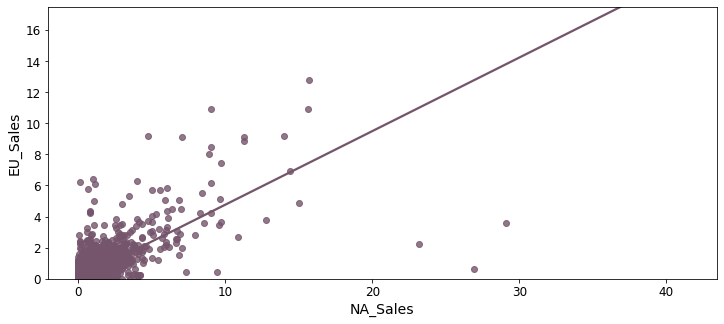

In [78]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.regplot(x="NA_Sales", y="EU_Sales", data=games, ci=None, color="#75556c", x_jitter=.02).set(ylim=(0, 17.5))

# By that, build two models:
- Based on sales in North America, predict sales in Europe
- Based on Critic Score, predict global sales

In [54]:
features = ['Critic_Score']
target = ['Global_Sales']

In [55]:
# split data into feature and sale. Many sales column (by region), that we can target separetly
y = games[target].copy()
#X = games_with_score.drop(["Name","Year_of_Release","Platform", "Genre", "Publisher","Developer","Rating","NA_Sales","EU_Sales","JP_Sales","Other_Sales", "Global_Sales"], axis=1)
X = games[features].copy()

In [56]:
# Now, split both X and y data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=0.2, 
                                       random_state=42)

In [57]:
# Create a local instance of the sklearn class
lin_reg = LinearRegression()

In [58]:
# Fit your instance to the training dataset
lin_reg.fit(X_train, y_train)

LinearRegression()

In [59]:
lin_score_train = lin_reg.score(X_test, y_test)
lin_score_test = lin_reg.score (X_train, y_train)

In [60]:
print("Training score: ",lin_score_train)
print("Testing score: ",lin_score_test)

Training score:  0.047803197789119456
Testing score:  0.0358391046707226


In [61]:
# Make predictions on the testing dataset
y_preds = lin_reg.predict(X_test)

In [62]:
# Print the coefficients.
print(lin_reg.intercept_)
print(lin_reg.coef_)

[-1.75146673]
[[0.03336379]]


In [86]:
m = lin_reg.predict([[30],[80],[99]])
m

array([[-0.75055314],
       [ 0.91763619],
       [ 1.55154813]])

In [63]:
# Evaluation. What do these mean?
print('mae', mean_absolute_error(y_test, y_preds))
print('rmse', np.sqrt(mean_squared_error(y_test, y_preds)))
print('R2', r2_score(y_test, y_preds))

mae 0.6561516467532238
rmse 1.450185285871658
R2 0.047803197789119456


In [64]:
# try KNN
from sklearn import neighbors
n_neighbors=5
knn_reg=neighbors.KNeighborsRegressor(n_neighbors,weights='uniform')
knn_reg.fit(X_train, y_train)

KNeighborsRegressor()

In [65]:
knn_score_train = knn_reg.score(X_test, y_test)
knn_score_test = knn_reg.score(X_train, y_train)

print("Training score: ",knn_score_train)
print("Testing score: ",knn_score_test)

Training score:  -0.06499956679326657
Testing score:  -0.006817962753199902


In [66]:
# Make predictions on the testing dataset
y_preds = knn_reg.predict(X_test)

In [83]:
m = knn_reg.predict([[30],[80],[90]])

In [84]:
m

array([[0.308],
       [1.974],
       [1.364]])

In [69]:
y_preds

array([[0.226],
       [0.56 ],
       [0.226],
       ...,
       [0.226],
       [0.424],
       [0.282]])

In [67]:
# Evaluation. What do these mean?
print('mae', mean_absolute_error(y_test, y_preds))
print('rmse', np.sqrt(mean_squared_error(y_test, y_preds)))
print('R2', r2_score(y_test, y_preds))

mae 0.6170131438721137
rmse 1.5336803402748724
R2 -0.06499956679326657
